In [35]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [36]:
IMAGE_SIZE = [290, 290]

In [37]:
train_path="../datasets/dataset/train"
test_path="../datasets/dataset/test"
val_path="../datasets/dataset/val"

In [38]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(290,290))
        x_train.append(img_arr)

In [39]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(290,290))
        x_test.append(img_arr)

In [40]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(290,290))
        x_val.append(img_arr)

In [41]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [42]:
train_x.shape,test_x.shape,val_x.shape

((4800, 290, 290, 3), (600, 290, 290, 3), (600, 290, 290, 3))

In [43]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [45]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (290, 290),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (290, 290),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (290, 290),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 4800 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [46]:
training_set.class_indices

{'blurred': 0, 'original': 1, 'skewed': 2}

In [47]:
train_y=training_set.classes

In [48]:
test_y=test_set.classes

In [49]:
val_y=val_set.classes

In [50]:
train_y.shape,test_y.shape,val_y.shape

((4800,), (600,), (600,))

In [51]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [52]:
for layer in vgg.layers:
    layer.trainable = False

In [53]:
x = Flatten()(vgg.output)

prediction = Dense(3, activation='softmax')(x)

In [54]:
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 290, 290, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 290, 290, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 290, 290, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 145, 145, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 145, 145, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 145, 145, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 72, 128)       0   

In [55]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [56]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [57]:
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
150/150 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9910WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000018507340438> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

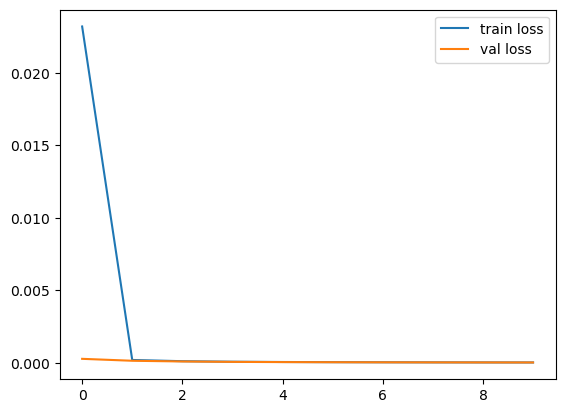

In [58]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('model_loss.png')
plt.show()

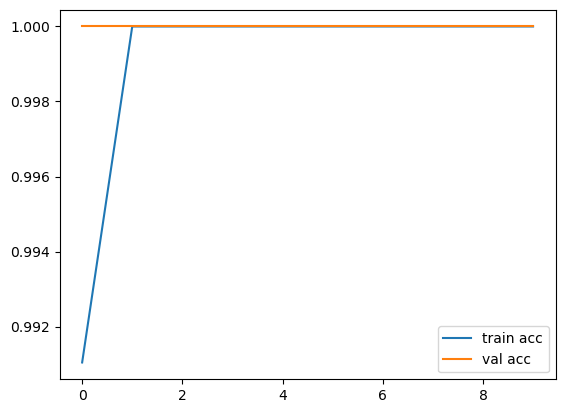

In [59]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('model_accuracy.png')
plt.show()

In [60]:
model.evaluate(test_x,test_y,batch_size=32)

19/19 [==============================] - 159s 8s/step - loss: 1.6377e-05 - accuracy: 1.0000


[1.6377418432966806e-05, 1.0]

In [61]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
accuracy_score(y_pred,test_y)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - 166s 9s/step


1.0

In [62]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [63]:
confusion_matrix(y_pred,test_y)

array([[200,   0,   0],
       [  0, 200,   0],
       [  0,   0, 200]], dtype=int64)

In [64]:
model.save("cv_vgg_model.h5")